In [1]:
from stable_baselines3 import PPO

In [2]:
model = PPO.load('./ppo_data/best_model.zip')

In [3]:
model.policy

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential()
    (policy_net): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=1, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

In [4]:
mlp_extractor_state_dict = model.policy.mlp_extractor.policy_net.state_dict()
action_net = model.policy.action_net.state_dict()

In [5]:
import torch
import torch.nn as nn
# from torch.nn.functional import one_hot, log_softmax, softmax, normalize

class Agent(nn.Module):

    '''
    This class defines a neural network as an agent. 
    The agent takes in observation and returns an action.
    '''

    def __init__(self, observation_space_size: int, action_space_size: int, hidden_size: int):
        super(Agent, self).__init__()

        torch.manual_seed(0)
        
        self.layer_1 = nn.Linear(in_features=observation_space_size, out_features=hidden_size, bias=True)
        self.layer_2 = nn.Linear(in_features=hidden_size, out_features=hidden_size, bias=True)
        self.layer_3 = nn.Linear(in_features=hidden_size, out_features=action_space_size, bias=True)
        self.activation_function = nn.Tanh()

    def forward(self, x):
        
        x = self.activation_function(self.layer_1(x))
        x = self.activation_function(self.layer_2(x))
        x = self.layer_3(x)
        
        return x 

In [6]:
leanred_policy = Agent(observation_space_size = 6,
                      action_space_size = 1,
                      hidden_size = 64)

In [7]:
with torch.no_grad():
    leanred_policy.layer_1.weight.copy_(mlp_extractor_state_dict['0.weight'])
    leanred_policy.layer_1.bias.copy_(mlp_extractor_state_dict['0.bias'])
    leanred_policy.layer_2.weight.copy_(mlp_extractor_state_dict['2.weight'])
    leanred_policy.layer_2.bias.copy_(mlp_extractor_state_dict['2.bias'])
    leanred_policy.layer_3.weight.copy_(action_net['weight'])
    leanred_policy.layer_3.bias.copy_(action_net['bias'])
    
leanred_policy = leanred_policy.to('cpu')

In [8]:
import trading_vix_env

In [9]:
env = trading_vix_env.trading_vix_env()
env.seed(0)

/home/zuhao/anaconda2/envs/p37/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [10]:
trading_action_percentage = []
trading_action_buy_sell = []
portfolio_value = []
stock_price = []

In [11]:
observation = env.reset()

trading_action_percentage.append(0) #start off with 0 in stock
trading_action_buy_sell.append(0) #neigher buy nor sell
portfolio_value.append(env.current_portfolio_value)
stock_price.append(observation[0])

while True:
    observation = torch.tensor(observation, dtype=torch.float)
    action_from_policy = leanred_policy(observation)
    action_from_policy = torch.clamp(action_from_policy,0,1)
    
    observation, reward, done ,info = env.step(action_from_policy.detach().numpy())
    
    #record data from the trajectory
    trading_action_percentage.append(action_from_policy.detach().numpy()[0])
    if info['execute_buy']:
        trading_action_buy_sell.append(1)
    elif info['execute_sell']:
        trading_action_buy_sell.append(-1)
    else:
        trading_action_buy_sell.append(0)
    portfolio_value.append(info['current_portfolio'])
    stock_price.append(observation[0])
    
    if done:
        break

the reward is 48.8753086393568


In [12]:
print(len(trading_action_percentage))
print(len(trading_action_buy_sell))
print(len(portfolio_value))
print(len(stock_price))

202
202
202
202


In [13]:
import matplotlib.pyplot as plt
import numpy as np

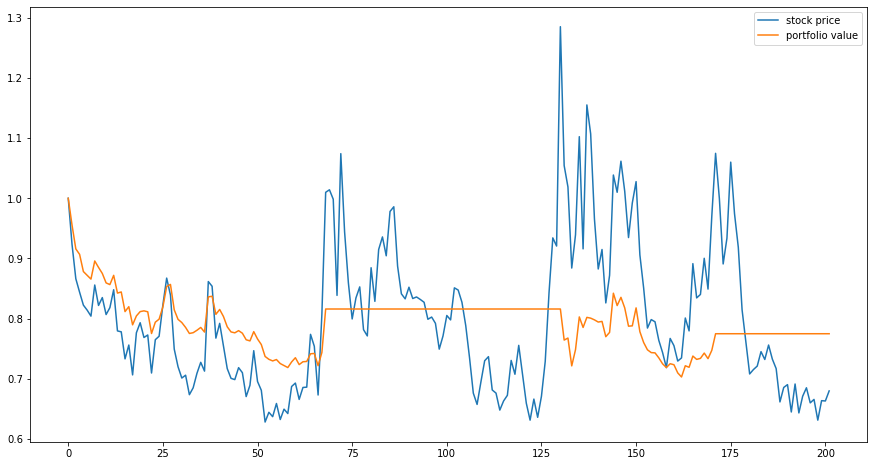

In [14]:
plt.rcParams["figure.figsize"] = (15,8)

plt.plot(np.asarray(stock_price)/stock_price[0],label = 'stock price')
plt.plot(np.asarray(portfolio_value)/portfolio_value[0],label = 'portfolio value')
plt.legend()
plt.show()

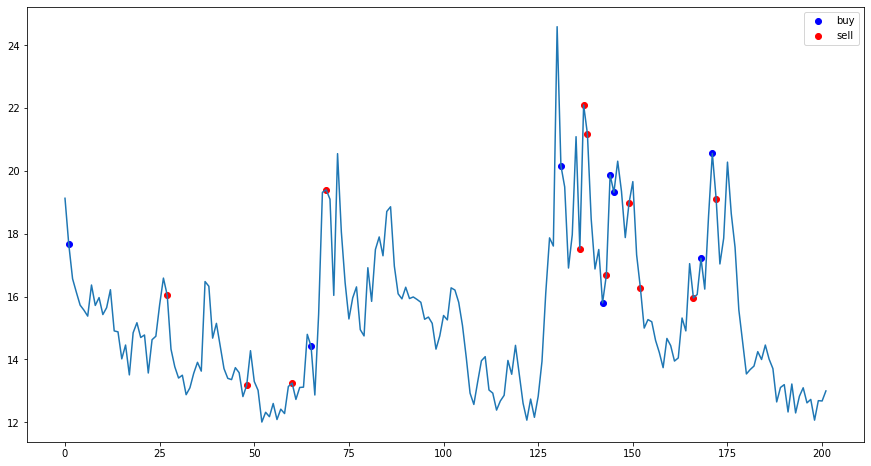

In [15]:


already_plotted_sell_legend = False
already_plotted_buy_legend = False

plt.plot(stock_price)
for time_index in range(0,len(trading_action_buy_sell)):

    if trading_action_buy_sell[time_index]==1:
        #print('the buy price is',price_history[time_index])
        if already_plotted_buy_legend == False:
            plt.scatter(time_index,stock_price[time_index],color = 'b',label = 'buy')
            already_plotted_buy_legend = True
        else:
            plt.scatter(time_index,stock_price[time_index],color = 'b')

    elif trading_action_buy_sell[time_index]==-1:
        #print('the sell price is',price_history[time_index])
        #print(' ')
        if already_plotted_sell_legend == False:
            plt.scatter(time_index,stock_price[time_index],color = 'r',label = 'sell')
            already_plotted_sell_legend = True
        else:
            plt.scatter(time_index,stock_price[time_index],color = 'r')
plt.legend()
plt.show()



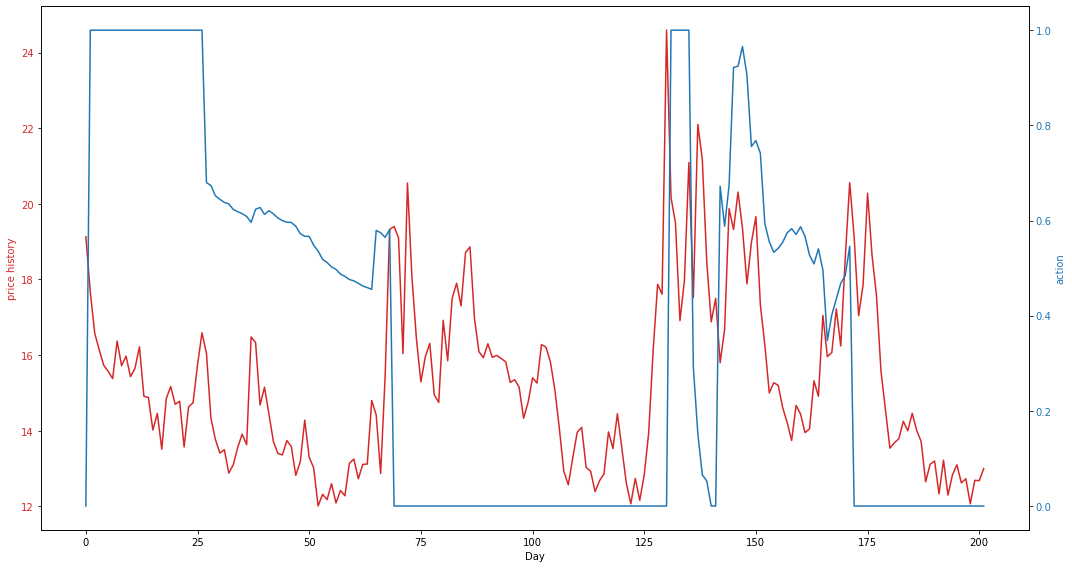

In [16]:
plt.rcParams["figure.figsize"] = (15,8)

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Day')
ax1.set_ylabel('price history', color=color)
ax1.plot(stock_price, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('action', color=color)  # we already handled the x-label with ax1
ax2.plot(trading_action_percentage, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [17]:
#call the evaluate policy from stablebale lines

env = trading_vix_env.trading_vix_env()
env.seed(0)

from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1, deterministic=True)

/home/zuhao/anaconda2/envs/p37/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/zuhao/anaconda2/envs/p37/lib/python3.7/site-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


the reward is 48.87530857754905


In [19]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=50, deterministic=True)

the reward is 98.72090891784474
the reward is -32.05224539985814
the reward is 68.854402835587
the reward is 144.88354159832895
the reward is 70.13449162015527
the reward is -0.8183738905606219
the reward is -15.40162905468793
the reward is 141.07765342000238
the reward is 35.20905105616944
the reward is 23.869541825413222
the reward is 108.94694769095454
the reward is -23.785611846180572
the reward is 70.96419737400137
the reward is 3.835477968717967
the reward is 250.61183394217758
the reward is 46.63838212568221
the reward is 110.91943341110924
the reward is -4.869162214177422
the reward is 78.37315309418658
the reward is 42.168679529475895
the reward is 50.768654868264676
the reward is -22.510842573596605
the reward is 24.861707659990316
the reward is 5.6253952411596515
the reward is -19.398786741813936
the reward is 24.909715718434754
the reward is 41.21983463906032
the reward is 39.27129588465861
the reward is 55.50787948941067
the reward is -12.154478995583915
the reward is 43.3

In [20]:
print('the mean reward is',mean_reward)
print('the std reward is',std_reward)

the mean reward is 58.500196113586426
the std reward is 58.63668971118396
